<a href="https://colab.research.google.com/github/OsirisEscaL/Parkinson_Project/blob/main/ExtraTreesClassifier_Parkinson_HeredetaryAtaxias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
ds = pd.read_csv('Parkinson_HeredetaryAtaxias.csv') # Cambiar dataset
ds = ds.drop(['Unnamed: 0'], axis=1)
X = ds.iloc[:, 0:-1].values
y = ds.iloc[:, -1].values

rng = np.random.default_rng(seed=42)
random = rng.integers(10000, size=50)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [3]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(random_state = 42)

In [4]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(scaled_X, y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['ExtraTreesClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_base = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
ExtraTreesClassifier,0.713429,0.483097,0.82937,0.750501,0.483097,0.931527,0.034667,0.017936,0.025125,0.011644,0.011132,0.025125,0.016507,0.044076


Oversampling

In [5]:
methods = [
    ("Random Over Sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ("ADASYN", ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)),
    ("BorderlineSMOTE", BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("SVMSMOTE", SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("KMeansSMOTE", KMeansSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2, cluster_balance_threshold=0.01))
]

In [6]:
results = {}
results_raw = {}

for method_name, method in methods:
    sample_x, sample_y = method.fit_resample(scaled_X, y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for num in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=num)
        for train_index, test_index in stratified_kfold.split(sample_x,sample_y):
            X_train, X_test = sample_x[train_index], sample_x[test_index]
            y_train, y_test = sample_y[train_index], sample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[method_name] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[method_name] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_over_ds = pd.DataFrame(results_raw)
results_raw_over_ds.to_csv('Results_Raw_Oversampling_ExtraTreesClassifier.csv')

results_over_ds = pd.DataFrame(results).T
results_over_ds.to_csv('Results_Oversampling_ExtraTreesClassifier.csv')
results_over_ds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
Random Over Sampler,0.930655,0.024635,0.930632,0.024825,0.939069,0.038273,0.931491,0.018770,0.929818,0.048916,0.931101,0.021918,0.930655,0.024635
SMOTE,0.891945,0.018361,0.892208,0.018607,0.894497,0.022361,0.900618,0.023579,0.883273,0.026035,0.893024,0.017973,0.891945,0.018361
ADASYN,0.917788,0.020087,0.919091,0.020671,0.949302,0.032783,0.886364,0.025004,0.949212,0.035052,0.912770,0.020669,0.917788,0.020087
BorderlineSMOTE,0.912236,0.016912,0.912000,0.017289,0.926103,0.026711,0.905855,0.020594,0.918618,0.032572,0.911080,0.016000,0.912236,0.016912
SVMSMOTE,0.855122,0.019067,0.867333,0.016984,0.870131,0.018421,0.923673,0.018725,0.786571,0.036829,0.891562,0.013302,0.855122,0.019067
KMeansSMOTE,0.886309,0.013686,0.885810,0.013922,0.869043,0.018023,0.918582,0.019888,0.854036,0.019118,0.888947,0.013770,0.886309,0.013686


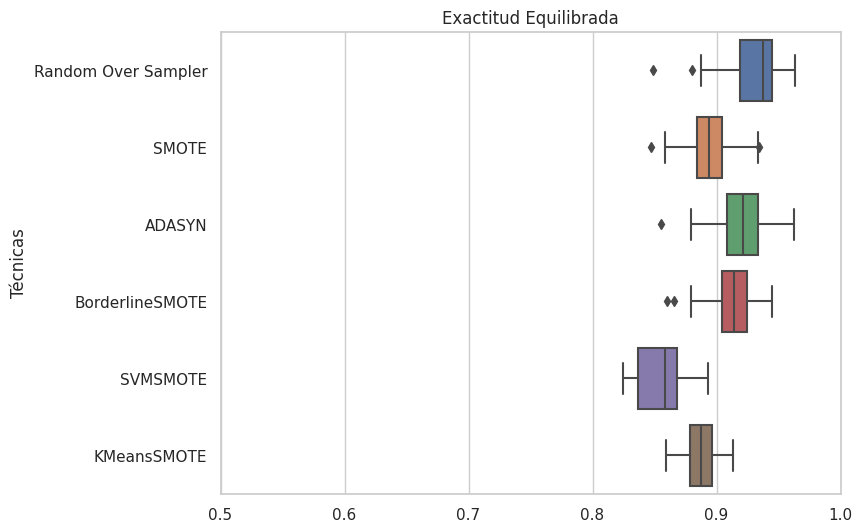

In [7]:
balanced_accuracy = pd.DataFrame(results_raw_over_ds.loc['Balanced_Accuracy'])
modelos = balanced_accuracy.index

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=balanced_accuracy['Balanced_Accuracy'], orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.5, 1)
plt.ylabel('Técnicas')
plt.gca().set_yticklabels(modelos)
plt.savefig('Boxplot_Oversampling_ExtraTreesClassifier.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
samplers = ['Random Over Sampler', 'SMOTE', 'ADASYN', 'BorderlineSMOTE',
            'SVMSMOTE', 'KMeansSMOTE']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = results_raw_over_ds.loc['Balanced_Accuracy', sample1]
  for sample2 in samplers:
    val2 = results_raw_over_ds.loc['Balanced_Accuracy', sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
      else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_Oversampling_ExtraTreesClassifier.csv')
comparison

statistic   p_value  \
Random Over Sampler Random Over Sampler    1250.0       1.0   
                    SMOTE                  2221.5       0.0   
                    ADASYN                 1711.0  0.000748   
                    BorderlineSMOTE        1888.0  0.000006   
                    SVMSMOTE               2453.0       0.0   
                    KMeansSMOTE            2304.5       0.0   
SMOTE               Random Over Sampler     278.5       1.0   
                    SMOTE                  1250.0       1.0   
                    ADASYN                  420.0       1.0   
                    BorderlineSMOTE         464.5       1.0   
                    SVMSMOTE               2288.0       0.0   
                    KMeansSMOTE            1480.5   0.11273   
ADASYN              Random Over Sampler     789.0   0.99927   
                    SMOTE                  2080.0       0.0   
                    ADASYN                 1250.0       1.0   
                    BorderlineSMOTE        1557.0  0.017282   
                    SVMSMOTE               2445.0       0.0   
                    KMeansSMOTE            2235.5       0.0   
BorderlineSMOTE     Random Over Sampler     612.0  0.999995   
                    SMOTE                  2035.5       0.0   
                    ADASYN                  943.0  0.983011   
                    BorderlineSMOTE        1250.0       1.0   
                    SVMSMOTE               2458.0       0.0   
                    KMeansSMOTE            2214.5       0.0   
SVMSMOTE            Random Over Sampler      47.0       1.0   
                    SMOTE                   212.0       1.0   
                    ADASYN                   55.0       1.0   
                    BorderlineSMOTE          42.0       1.0   
                    SVMSMOTE               1250.0       1.0   
                    KMeansSMOTE             240.0       1.0   
KMeansSMOTE         Random Over Sampler     195.5       1.0   
                    SMOTE                  1019.5   0.11273   
                    ADASYN                  264.5       1.0   
                    BorderlineSMOTE         285.5       1.0   
                    SVMSMOTE               2260.0       0.0   
                    KMeansSMOTE            1250.0       1.0   

                                                                                   greater  
Random Over Sampler Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
SMOTE               Random Over Sampler  La primera muestra no es significativamente ma...  
                    SMOTE                No hay evidencia suficiente para afirmar que l...  
                    ADASYN               La primera muestra no es significativamente ma...  
                    BorderlineSMOTE      La primera muestra no es significativamente ma...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...  
ADASYN              Random Over Sampler  La primera muestra no es significativamente ma...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE   

In [9]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42) # Cambiar dependiendo cual fue mejor
oversample_X, oversample_y = oversampler.fit_resample(scaled_X, y)

In [10]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(oversample_X,oversample_y):
        X_train, X_test = oversample_X[train_index], oversample_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['ExtraTreesClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_over = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
ExtraTreesClassifier,0.930632,0.930655,0.931101,0.939069,0.930655,0.931491,0.929818,0.024825,0.024635,0.021918,0.038273,0.024635,0.01877,0.048916


In [11]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

La primera muestra es significativamente mayor que la segunda.


Feature Selection

In [12]:
ds_X = ds.iloc[:, 0:-1]
features = ds_X.shape[1]

In [13]:
# SelectKBest
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectKBest(score_func=f_classif, k=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_selectK_ds = pd.DataFrame(results_raw)
results_raw_selectK_ds.to_csv('Results_Raw_SelectKBest_ExtraTreesClassifier.csv')

results_selectK_ds = pd.DataFrame(results).T
number_of_features = results_selectK_ds.index + 1
results_selectK_ds.insert(0, 'Number_Features', number_of_features)
results_selectK_ds = results_selectK_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_selectK_ds.to_csv('Results_SelectKBest_ExtraTreesClassifier.csv')
results_selectK_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
42,43,0.933964,0.025168,0.933835,0.025290,0.941207,0.037914,0.935855,0.014892,0.932073,0.048624,0.934813,0.021809,0.933964,0.025168
49,50,0.933309,0.025151,0.933238,0.025363,0.939241,0.039967,0.936873,0.018402,0.929745,0.050654,0.934319,0.021879,0.933309,0.025151
45,46,0.933309,0.026123,0.933238,0.026151,0.939685,0.039497,0.936509,0.016407,0.930109,0.049566,0.934234,0.023089,0.933309,0.026123
54,55,0.933236,0.023264,0.933091,0.023345,0.935285,0.037569,0.941564,0.017325,0.924909,0.048554,0.934615,0.020108,0.933236,0.023264
51,52,0.933018,0.025489,0.932883,0.025534,0.938286,0.038932,0.937018,0.017378,0.929018,0.048197,0.933999,0.022583,0.933018,0.025489


In [14]:
best_number_K = 43 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_K = SelectKBest(score_func=f_classif, k=best_number_K)
new_X_K = selector_K.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_K.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectKBest:")
print(selected_feature_names)

Características seleccionadas usando SelectKBest:
Index(['Cadence_Der', 'Mean_step_lenght_Der', 'Velocity_Der', 'RMS_AP_Der',
       'Freq_50_VER_Der', 'Freq_75_VER_Der', 'Freq_90_VER_Der',
       'Freq_100_VER_Der', 'IPSD_ML_Der', 'Freq_75_ML_Der', 'Freq_90_ML_Der',
       'Freq_100_ML_Der', 'IPSD_AP_Der', 'Freq_50_AP_Der', 'Freq_75_AP_Der',
       'Freq_90_AP_Der', 'Freq_100_AP_Der', 'Sym_VER_Der', 'Sym_AP_Der',
       'Stride_Reg_ML_Der', 'Stride_Reg_AP_Der', 'Step_Reg_VER_Der',
       'Cadence_Izq', 'Mean_step_lenght_Izq', 'Velocity_Izq', 'RMS_VER_Izq',
       'RMS_ML_Izq', 'RMS_AP_Izq', 'IPSD_VER_Izq', 'Freq_50_VER_Izq',
       'Freq_75_VER_Izq', 'Freq_90_VER_Izq', 'Freq_100_VER_Izq', 'IPSD_ML_Izq',
       'Freq_75_ML_Izq', 'Freq_90_ML_Izq', 'Freq_100_ML_Izq', 'IPSD_AP_Izq',
       'Freq_90_AP_Izq', 'Freq_100_AP_Izq', 'Stride_Reg_VER_Izq',
       'Step_Reg_VER_Izq', 'Step_Reg_AP_Izq'],
      dtype='object')


In [15]:
# SelectFromModel
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectFromModel(model, max_features=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_select_ds = pd.DataFrame(results_raw)
results_raw_select_ds.to_csv('Results_Raw_SelectM_ExtraTreesClassifier.csv')

results_select_ds = pd.DataFrame(results).T
number_of_features = results_select_ds.index + 1
results_select_ds.insert(0, 'Number_Features', number_of_features)
results_select_ds = results_select_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_select_ds.to_csv('Results_SelectM_ExtraTreesClassifier.csv')
results_select_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
27,28,0.927364,0.023625,0.927368,0.023749,0.942391,0.037995,0.920182,0.014963,0.934545,0.048788,0.927199,0.020136,0.927364,0.023625
41,42,0.927364,0.023625,0.927368,0.023749,0.942391,0.037995,0.920182,0.014963,0.934545,0.048788,0.927199,0.020136,0.927364,0.023625
30,31,0.927364,0.023625,0.927368,0.023749,0.942391,0.037995,0.920182,0.014963,0.934545,0.048788,0.927199,0.020136,0.927364,0.023625
31,32,0.927364,0.023625,0.927368,0.023749,0.942391,0.037995,0.920182,0.014963,0.934545,0.048788,0.927199,0.020136,0.927364,0.023625
32,33,0.927364,0.023625,0.927368,0.023749,0.942391,0.037995,0.920182,0.014963,0.934545,0.048788,0.927199,0.020136,0.927364,0.023625


In [16]:
best_number_M = 28 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_M = SelectFromModel(model, max_features=best_number_M)
new_X_M = selector_M.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_M.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['Cadence_Der', 'RMS_ML_Der', 'Freq_75_VER_Der', 'Freq_50_ML_Der',
       'Freq_75_ML_Der', 'IPSD_AP_Der', 'Freq_90_AP_Der', 'Freq_100_AP_Der',
       'Sym_VER_Der', 'Sym_AP_Der', 'Step_Reg_AP_Der', 'Mean_step_lenght_Izq',
       'RMS_ML_Izq', 'RMS_AP_Izq', 'Freq_50_VER_Izq', 'Freq_75_VER_Izq',
       'Freq_90_VER_Izq', 'Freq_100_VER_Izq', 'IPSD_ML_Izq', 'Freq_90_ML_Izq',
       'IPSD_AP_Izq', 'Freq_90_AP_Izq', 'Freq_100_AP_Izq'],
      dtype='object')


In [17]:
# RFE
results = {}
results_raw = {}

for num in range(1, features):
    selector = RFE(model, n_features_to_select=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_recursive_ds = pd.DataFrame(results_raw)
results_raw_recursive_ds.to_csv('Results_Raw_RFE_ExtraTreesClassifier.csv')

results_recursive_ds = pd.DataFrame(results).T
number_of_features = results_recursive_ds.index + 1
results_recursive_ds.insert(0, 'Number_Features', number_of_features)
results_recursive_ds = results_recursive_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_recursive_ds.to_csv('Results_RFE_ExtraTreesClassifier.csv')
results_recursive_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
6,7,0.934455,0.024131,0.934468,0.024466,0.957580,0.037244,0.917273,0.013082,0.951636,0.045495,0.933451,0.021231,0.934455,0.024131
31,32,0.934127,0.023337,0.934017,0.023525,0.938725,0.036718,0.938909,0.016066,0.929345,0.047654,0.935135,0.020168,0.934127,0.023337
54,55,0.933582,0.024101,0.933489,0.024292,0.935826,0.037524,0.941891,0.015181,0.925273,0.048148,0.935038,0.021143,0.933582,0.024101
51,52,0.933291,0.028511,0.933143,0.028628,0.939522,0.040786,0.936436,0.021577,0.930145,0.051078,0.934378,0.025960,0.933291,0.028511
7,8,0.932545,0.024062,0.932545,0.024290,0.947404,0.039826,0.925527,0.013449,0.939564,0.049406,0.932509,0.020734,0.932545,0.024062


In [18]:
best_number_R = 7 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_R = RFE(model, n_features_to_select=best_number_R)
new_X_R = selector_R.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_R.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['Freq_90_AP_Der', 'Freq_100_AP_Der', 'Sym_VER_Der', 'RMS_ML_Izq',
       'RMS_AP_Izq', 'Freq_75_VER_Izq', 'Freq_90_VER_Izq'],
      dtype='object')


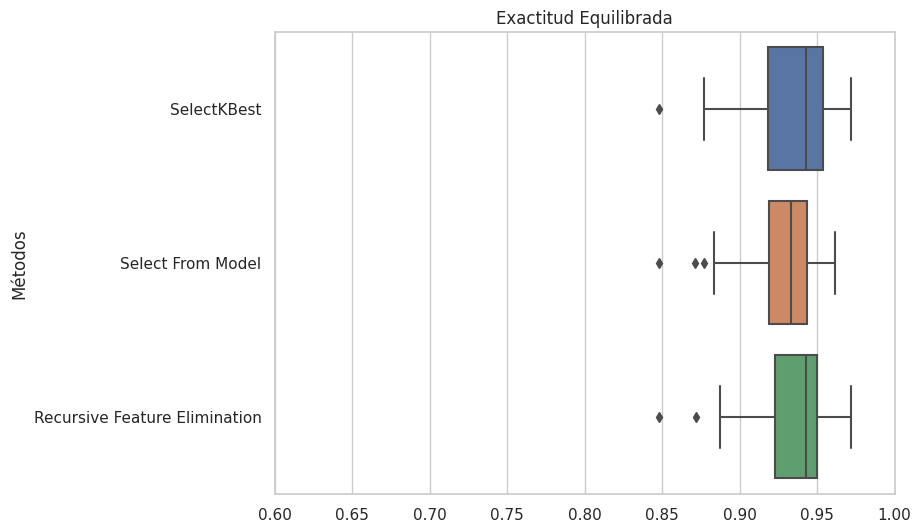

In [20]:
raw_SelectKBest = results_raw_selectK_ds.iloc[0, best_number_K-1]
raw_SelectM = results_raw_select_ds.iloc[0, best_number_M-1]
raw_RFE = results_raw_recursive_ds.iloc[0, best_number_R-1]

raw_SelectKBest = pd.Series(raw_SelectKBest, name='SelectKBest')
raw_SelectM = pd.Series(raw_SelectM, name='Select From Model')
raw_RFE = pd.Series(raw_RFE, name='Recursive Feature Elimination')

FeaturesSelectors = pd.concat([raw_SelectKBest, raw_SelectM, raw_RFE], axis=1)

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=FeaturesSelectors, orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.6, 1)
plt.ylabel('Métodos')
plt.savefig('Boxplot_FeatureSelection_ExtraTreesClassifier.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
samplers = ['SelectKBest', 'Select From Model',
            'Recursive Feature Elimination']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = FeaturesSelectors.loc[:, sample1]
  for sample2 in samplers:
    val2 = FeaturesSelectors.loc[:, sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
      else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_FeaturesSelection_ExtraTreesClassifier.csv')
comparison

statistic  \
SelectKBest                   SelectKBest                      1250.0   
                              Select From Model                1513.0   
                              Recursive Feature Elimination    1265.0   
Select From Model             SelectKBest                       987.0   
                              Select From Model                1250.0   
                              Recursive Feature Elimination    1005.5   
Recursive Feature Elimination SelectKBest                      1235.0   
                              Select From Model                1494.5   
                              Recursive Feature Elimination    1250.0   

                                                              p_value  \
SelectKBest                   SelectKBest                         1.0   
                              Select From Model              0.070137   
                              Recursive Feature Elimination  0.920296   
Select From Model             SelectKBest                    0.070137   
                              Select From Model                   1.0   
                              Recursive Feature Elimination  0.092306   
Recursive Feature Elimination SelectKBest                    0.920296   
                              Select From Model              0.092306   
                              Recursive Feature Elimination       1.0   

                                                                                                       greater  
SelectKBest                   SelectKBest                    No hay evidencia suficiente para afirmar que l...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...  
Select From Model             SelectKBest                    No hay evidencia suficiente para afirmar que l...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...  
Recursive Feature Elimination SelectKBest                    No hay evidencia suficiente para afirmar que l...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...

In [22]:
best_number = 7 # Cambiar dependiendo cual fue mejor
selector = RFE(model, n_features_to_select=best_number) # Cambiar dependiendo cual fue mejor
new_X = selector.fit_transform(oversample_X, oversample_y)

In [23]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['ExtraTreesClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_select = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
ExtraTreesClassifier,0.934468,0.934455,0.933451,0.95758,0.934455,0.917273,0.951636,0.024466,0.024131,0.021231,0.037244,0.024131,0.013082,0.045495


In [24]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 1342.5 p_value 0.5255593526556447 No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.


Hyperparameter Tunning

In [28]:
parameters = {

    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=50,  scoring='balanced_accuracy')
grid_search.fit(new_X, oversample_y)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [30]:
model_hyper = ExtraTreesClassifier(n_estimators= 50,criterion= 'gini', max_depth= 10, max_features= 'sqrt',
                                    min_samples_leaf= 1, min_samples_split= 2, random_state = 42)

In [31]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model_hyper.fit(X_train, y_train)
        y_pred = model_hyper.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['ExtraTreesClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_hyper = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
ExtraTreesClassifier,0.929905,0.929909,0.928522,0.95634,0.929909,0.909055,0.950764,0.024889,0.024498,0.021647,0.040366,0.024498,0.015205,0.048216


In [32]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 1095.0 p_value 0.2863726406043523 No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.


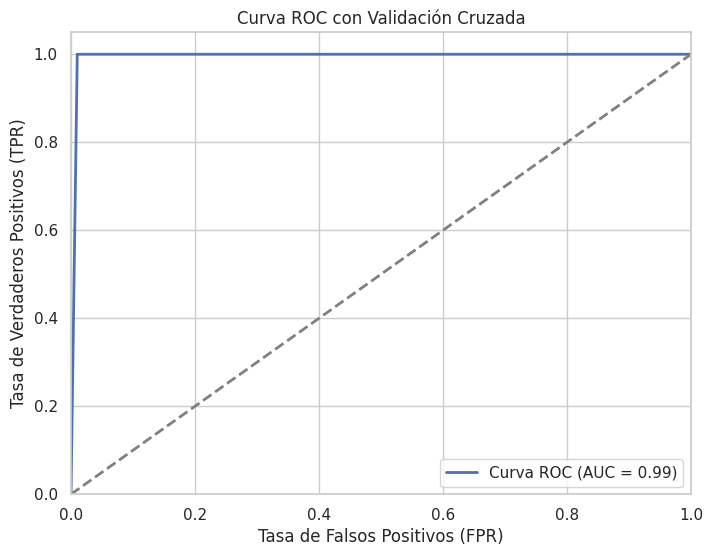

In [34]:
model_best = model #Cambie para colocar el parametro probability
cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, test_index in cv.split(new_X, oversample_y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = oversample_y[train_index], oversample_y[test_index]
    model_best.fit(X_train, y_train)
    y_pred_prob = model_best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

mean_tpr = np.mean(tprs, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.savefig('ROCCurve_DecisionTreeClassifier.png', dpi=300, bbox_inches='tight')
plt.show()